In [11]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import brenth

%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [12]:
np.random.seed(1234)
import pymc
import scipy.stats as stats

## Estimating parameters of the 1DHL flash method response

### One Dimensional Model with heat losses
Analytical formula for temperature response at the rear face of the sample ($x=L$, $t>0$) is
$$ T(t, a, B_1, B_2) = \sum_{i=0}^\infty \frac{ 2\gamma_i^2(\gamma_i^2+B_2^2)\big(\cos{\gamma_i}+\frac{B_1}{\gamma_i}\sin{\gamma_i}\big)}{(\gamma_i^2+B_1^2)(\gamma_i^2+B_2^2)+(B_1+B_2)(\gamma_i^2+B_1B_2)}\exp{\big[-\gamma_i^2\frac{at}{L^2}\big]}, $$
where $\gamma_i$, $i=1,2,3,\dots$, are positive roots of 
$$ (\gamma^2-B_1B_2)\sin{\gamma} - (B_1+B_2)\cos{\gamma}=0.$$

$B_1$ and $B_2$ are Biot numbers for the front and rear side of the sample, resp. 

In [13]:
def rootsearch(f,a,b,Bio,dx):
    x1 = a; f1 = f(a, Bio)
    x2 = a + dx; f2 = f(x2, Bio)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2, Bio)
    return x1,x2


def mroots(f, Bio, a, b, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a,b,Bio,eps)
        if x1 != None:
            a = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, Bio, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break

def funA(x,Bio): 
    return (x*x-Bio*Bio)*np.sin(x) - (Bio+Bio)*x*np.cos(x)
    

In [14]:
def flash1DHL( a, b, c, t,): # One dimensional model with heat losses
    
    # calculate eigenvalues - root of the transcendental functions
    gamas = mroots(funA, b, 0.0001, 200)
    
    Bi1=b
    Bi2=b

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)  
    
    return c*suma

In [53]:
# observed data
n = 25 # number of experimental points
a = 0.5 # diffusivity
c = 2 # tmax
#Bio = 0.50
L = 1.0 # thickness
b = 0.5 # Biot number
sigma = 0.05
x = np.linspace(0.01, 1.5, n)

y_obs = flash1DHL(a, b, c, x) + np.random.normal(0, sigma, n)
data = pd.DataFrame(np.array([x, y_obs]).T, columns=['x', 'y'])

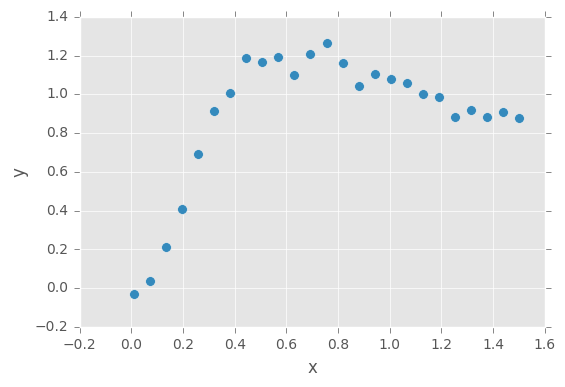

In [54]:
data.plot(x='x', y='y', kind='scatter', s=50);

In [85]:
# define priors
#a = pymc.Gamma('alpha', alpha=0.6, beta=0.1)
#b = pymc.Gamma('biot', alpha=0.1, beta=0.1)
#c = pymc.Gamma('tmax', alpha=1.5, beta=0.1)
#tau = pymc.Gamma("tau", alpha=0.01, beta=0.01)
#a = pymc.Normal('alpha', mu=0.45, tau=1.0/10**2)
#b = pymc.Normal('biot', mu=0.09, tau=1.0/10**2)
#c = pymc.Normal('tmax', mu=1.99, tau=1.0/10**2)
#tau = pymc.Gamma("tau", alpha=0.01, beta=0.01)
#a = pymc.Uniform('alpha',0.0, 1.0)
#b = pymc.Uniform('biot', 0.6, 0.9)
#c = pymc.Uniform('tmax', 0.0, 5)
#tau = pymc.Normal("tau", 0.1, 0.0001)

a = pymc.Normal('alpha', mu=0.1, tau=20)
b = pymc.Normal('tmax', mu=1, tau=2.0/10**0)
c = pymc.Normal('biot', mu=0.6, tau=20.0/10**0)
tau = pymc.Gamma("tau", alpha=0.8, beta=0.8)

# define likelihood
@pymc.deterministic
def mu( a=a, b=b, c=c, x=x): # One dimensional model with heat losses
    
    # calculate eigenvalues - root of the transcendental functions
    gamas = mroots(funA, b, 0.001, 200)
    
    Bi1 = b
    Bi2 = b

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*x/L**2)  
    
    return c*suma

y = pymc.Normal('y', mu=mu, value=y_obs, observed=True)

# inference
m = pymc.Model([a, b, c, tau, x, y])
mc = pymc.MCMC(m)
mc.sample(iter=1000, burn=400)

 [-----------------58%--                ] 587 of 1000 complete in 131.8 sec

C:\Users\jgembarovic\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: RuntimeWarning: overflow encountered in exp
C:\Users\jgembarovic\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: RuntimeWarning: invalid value encountered in add


 [-----------------100%-----------------] 1000 of 1000 complete in 235.6 sec

C:\Users\jgembarovic\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


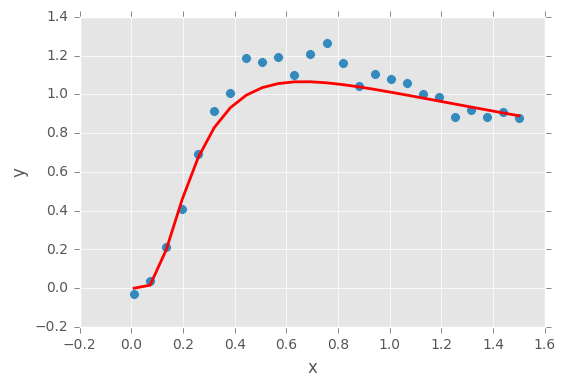

In [86]:
abar = a.stats()['mean']
bbar = b.stats()['mean']
cbar = c.stats()['mean']
data.plot(x='x', y='y', kind='scatter', s=50);
xp = np.array(x)  #[x.min(), x.max()])
#plt.plot(xp, flash1DHL(a.trace(), b.trace(),c.trace(), xp[:, None]), c='red', alpha=0.01)
plt.plot(xp, flash1DHL(abar,bbar, cbar,xp), linewidth=2, c='red');

Plotting biot
Plotting alpha
Plotting tmax
Plotting tau


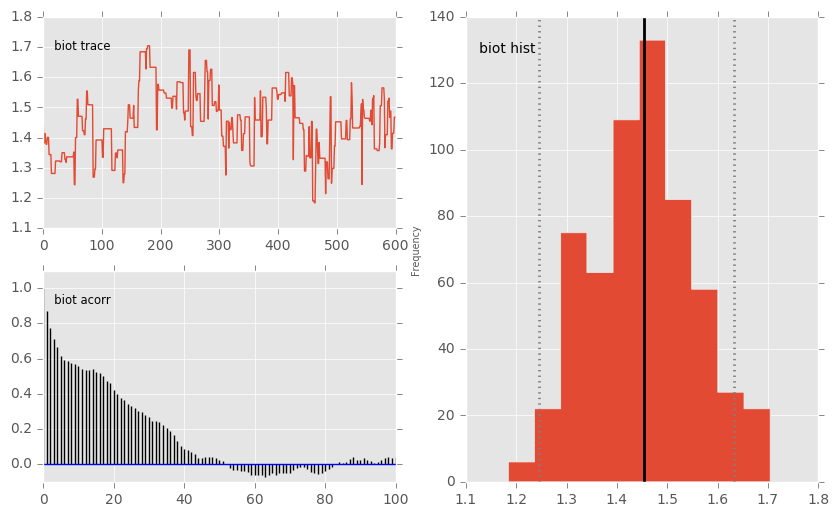

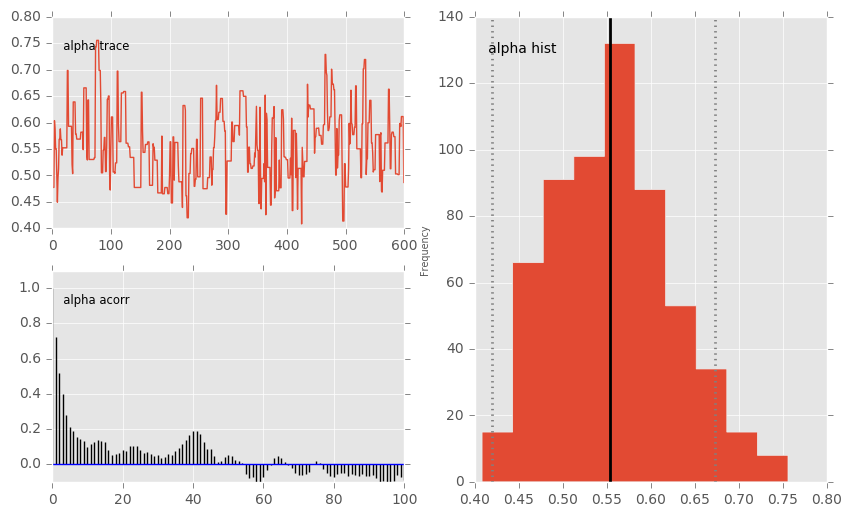

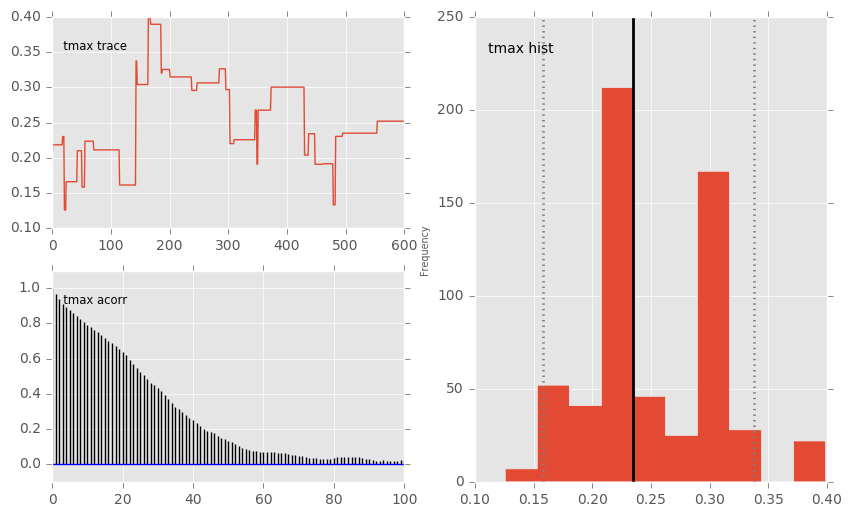

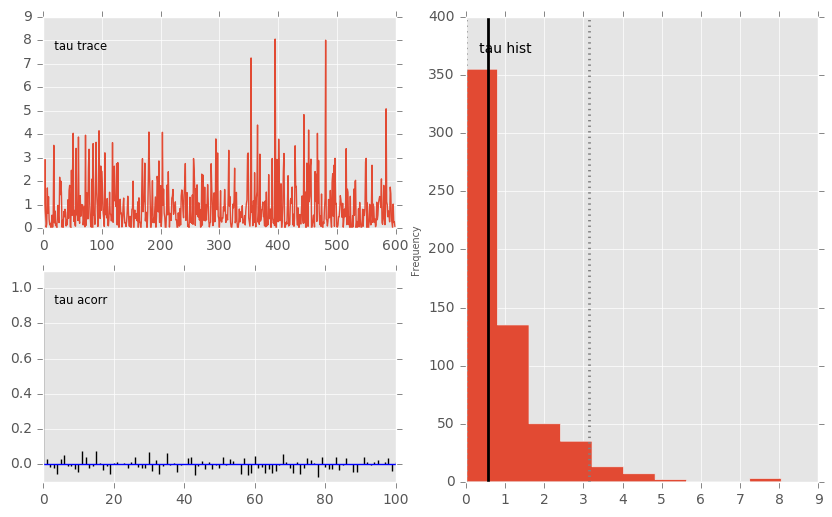

In [87]:
pymc.Matplot.plot(mc, )

In [70]:

import numpy as np
samples = np.array([a.trace(),b.trace(), c.trace(), tau.trace()]).T
pip install corner or pip install triangle_plot
import corner
figure = corner.corner(samples, color="b", bins=30, filled= True, smooth=(1.5),fill_contours=False,
                       labels=['alpha','biot', 'tmax', 'tau'], 
                truths=[0.5, 0.1,2.0, tau])

SyntaxError: invalid syntax (<ipython-input-70-e4107d45144f>, line 4)

In [71]:
abar = a.stats()['mean']
bbar = b.stats()['mean']
cbar = c.stats()['mean']
abar, bbar, cbar

C:\Users\jgembarovic\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


(0.5428, 0.7492, 2.5877)